## Problem 8.1: A hierarchical model for cell viability on biomaterials, 60 points

**Note:** *This problem deals with unpublished research. The authors kindly donated the data set and shared their research and ask that you not disseminate this problem nor its data set beyond the context of this course.*

The [Kornfield lab](http://kornfield.caltech.edu) at Caltech does interesting work at the interfaces of polymer chemistry, polymer physics, and therapeutics with biomaterials. As they develop interesting materials that will interface with the human body, they test to see how different cell types will respond to the material. They are currently developing a material called PLA and did the following assay. They exposed [human umbilical vein endothelial cells](https://en.wikipedia.org/wiki/Human_umbilical_vein_endothelial_cell) (HUVEC) to their PLA material for 24 hours. They then tested the viability of the cells by performing a metabolic assay. The subject the cells to WST-1, a tetrazolium salt. In viable cells, mitochondrial dehydrogenases cleave WST-1, which gives a product that absorbs light in the 450 nm range. This allows for optical quantification of cell viability.

Zach Shao and his coworkers in the Kornfield lab performed this assay on three different varieties of their PLA material. They also performed a control experiment where the cells were grown up absent of any of the PLA material. They also did a negative control experiment in which the cells were treated with a detergent that distrupts the cell membrane. The results from the assay are given in arbitrary units, but those units are consistent throughout the experiments. You can download the data set [here](http://bebi103.caltech.edu/2018_protected/data/shao_et_al_wst-1_assay.csv).

**a)** Perform some exploratory data analysis to investigate the data set.

We will begin by importing the tools of the trade.

In [1]:
# Our numerical workhorses
import numpy as np
import pandas as pd
import bebi103
import pystan

# Import Altair for high level plotting
import altair as alt
import altair_catplot as altcat
# Pevent bulky altair plots
alt.data_transformers.enable('json')

# Import Bokeh modules for interactive plotting
import bokeh.io
import bokeh.plotting
# Set up Bokeh for inline viewing
bokeh.io.output_notebook()

Loading BokehJS ...

We now import and tidy up the data:

In [28]:
df = pd.read_csv('../data/shao_et_al_wst-1_assay.csv', comment='#')
# Change "One" to 1 in Experiment column. 
col_names = {"One":1, "Two":2, "Three":3}
arr = df["Experiment"].values
exp = np.zeros(len(arr), dtype=int)
for i in range(0, len(arr)):
    exp[i] = col_names[arr[i]]
df["Experiment"] = exp
# Peek at data
df.head()

,Treatment,Experiment,assay_result
0,Control,1,1.45945
1,Control,1,1.51035
2,Control,1,1.80045
3,Control,1,1.83745
4,PLA_1,1,1.42015


and then produce a simple plot using altair.

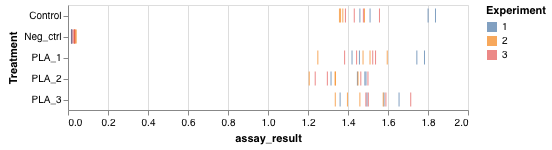

In [29]:
alt.Chart(df).mark_tick().encode(
        x='assay_result:Q',
        y='Treatment:N',
        color = alt.Color('Experiment:N'),
    )

From this plot, we can clearly see that the negative control cells have nearly zero absorbance, but each PLA is not clearly better or worse than the other. Due to exceptionally low negative controls, I will omit them from the following ECDFs. 

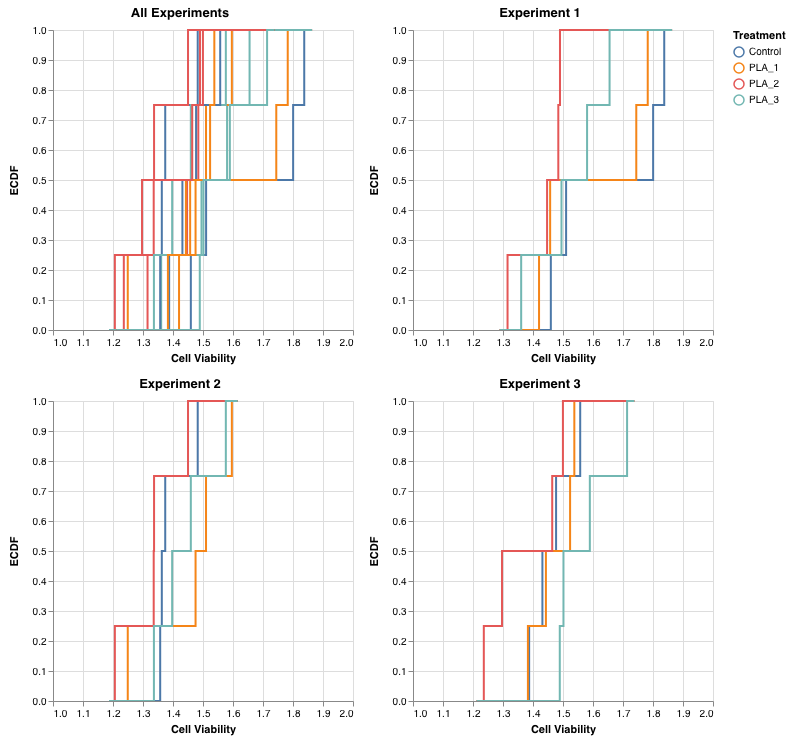

In [38]:
def make_ecdf(bool_index, title):
    c = altcat.catplot(data=df_no_control.loc[bool_index,:],
               mark='line',
               encoding=dict(x=alt.X('assay_result:Q',
                                     scale=alt.Scale(
                                           domain=(1, 2),
                                           clamp=True),
                                    title = "Cell Viability"),
                             color = alt.Color('Treatment:N', title='Treatment')),
               transform='ecdf'
              ).properties(height=300,
                           width=300,
                           title = title)
    return c
df_no_control = df[df["Treatment"] != "Neg_ctrl"]
# Segregate data by experiment
E1 = df_no_control['Experiment'] == 1
E2 = df_no_control['Experiment'] == 2
E3 = df_no_control['Experiment'] == 3

(((make_ecdf(E1, "All Experiments") 
 + make_ecdf(E2, "All Experiments") 
 + make_ecdf(E3, "All Experiments")) 
 | make_ecdf(E1, "Experiment 1")) 
 &(make_ecdf(E2, "Experiment 2") 
 | make_ecdf(E3, "Experiment 3")))

PLA 2 seems to be the worst in terms of cell viability, but the best material seems to vary between experiments. We will now transition to hierarchical modeling. 

**b)** Construct a hierarchical model describing the results. Because you are not familiar with this kind of experiment, it will be hard to construct priors. In doing so, assume that a typical assay value for a reasonably viable group of cells is about unity, and the typical baseline (absence of viable cells) does not go much beyond 0.05. Note that constructing the hierarchical model involes performing prior predictive checks. Note also that you may need to consider some pragmatic tradeoffs when doing your prior predictive checks (such as occasional unphysical results). 

As you are specifying the data inputs to your model, it may be useful to know that you can change the name of a dictionary key in Python using

```python
my_dict[new_key] = my_dict.pop[old_key]
```

You can also [merge two dictionaries](https://treyhunner.com/2016/02/how-to-merge-dictionaries-in-python/).

**c)** The authors are interested in the ratio of the PLA assay results to control. Using your hierarchical model, perform parameter estimation to compare the ratios PLA-1/control, PLA-2/control, and PLA-3/control. *Hint*: When you do not have much data, such as is the case here, using a noncentered parametrization is often very important.